In [1]:
PROJECT_ROOT = "/home/vladislav/experiments/texts-similarity"

In [2]:
import sys  
sys.path.insert(1, PROJECT_ROOT)

In [3]:
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler

from datasets.siamese.siamese_dataset import SiameseNetworkDataset
from determining.random_settings import determine_random
from losses.contrastive_loss import ContrastiveLoss
from statistic.metrics import Metrics

In [4]:
# create the Siamese Neural Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu')
        self.train_stat: list[Metrics] = list()
        self.test_stat: Metrics | None = None

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 2)
        )

    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2


In [5]:
def train(args, model: SiameseNetwork, device, train_loader: DataLoader, optimizer, epoch: int) -> None:
    model.train()
    criterion = ContrastiveLoss()
    loss: Tensor | None = None
    
    for batch_idx, (images_1, images_2, targets) in enumerate(train_loader, 0):
        images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
        optimizer.zero_grad()
        output1, output2 = model(images_1, images_2)
        loss = criterion(output1, output2, targets)
        loss.backward()
        optimizer.step()
        if args.dry_run:
            print(f'Epoch: {epoch} \tLoss: {loss.item()}')
            break
    print(f'Epoch: {epoch} \tLoss: {loss.item()}')


In [6]:
def test(model, device, test_loader: DataLoader) -> Metrics:
    model.eval()

    criterion = ContrastiveLoss()

    y_true = []
    y_pred = []
    loss: Tensor | None = None

    with torch.no_grad():
        for (images_1, images_2, targets) in test_loader:
            images_1, images_2, targets = images_1.to(
                device), images_2.to(device), targets.to(device)
            output1, output2 = model(images_1, images_2)
            # sum up batch loss
            loss = criterion(output1, output2, targets)
            pred = 0 if F.pairwise_distance(output1, output2).item() < 1.0 else 1

            y_pred.append(pred)
            y_true.extend(targets.detach().cpu().numpy())

    return Metrics(y_true=torch.from_numpy(np.array(y_true)), y_pred=torch.from_numpy(np.array(y_pred)), loss=loss.item())


In [9]:
def main() -> None:
    # Training settings
    parser = argparse.ArgumentParser(
        description='PyTorch Siamese network Example')
    parser.add_argument(
        '--batch-size',
        type=int,
        default=64,
        metavar='N',
        help='input batch size for training (default: 64)'
    )
    parser.add_argument(
        '--test-batch-size',
        type=int,
        default=1,
        metavar='N',
        help='input batch size for testing (default: 1000)'
    )
    parser.add_argument(
        '--epochs',
        type=int,
        default=100,
        metavar='N',
        help='number of epochs to train (default: 100)'
    )
    parser.add_argument(
        '--lr',
        type=float,
        default=1.0,
        metavar='LR',
        help='learning rate (default: 1.0)'
    )
    parser.add_argument(
        '--gamma',
        type=float,
        default=0.7,
        metavar='M',
        help='Learning rate step gamma (default: 0.7)'
    )
    parser.add_argument(
        '--no-cuda',
        action='store_true',
        default=False,
        help='disables CUDA training'
    )
    parser.add_argument(
        '--no-mps',
        action='store_true',
        default=False,
        help='disables macOS GPU training'
    )
    parser.add_argument(
        '--dry-run',
        action='store_true',
        default=False,
        help='quickly check a single pass'
    )
    parser.add_argument(
        '--seed',
        type=int,
        default=134,
        metavar='S',
        help='random seed (default: 1)'
    )
    parser.add_argument(
        '--log-interval',
        type=int,
        default=10,
        metavar='N',
        help='how many batches to wait before logging training status'
    )
    parser.add_argument(
        '--save-model',
        action='store_true',
        default=False,
        help='For Saving the current Model'
    )
    args = parser.parse_args([])

    use_cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    determine_random(args.seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}

    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    print(f"Running on {device}")

    # Resize the images and transform to tensors
    transformation = transforms.Compose(
        [transforms.Resize((100, 100)), transforms.ToTensor()])

    train_dataset = SiameseNetworkDataset(
        image_folder_dataset=datasets.ImageFolder(
            root=f"{PROJECT_ROOT}/datasets/siamese/data/faces/training/"),
        transform=transformation)
    test_dataset = SiameseNetworkDataset(
        image_folder_dataset=datasets.ImageFolder(
            root=f"{PROJECT_ROOT}/datasets/siamese/data/faces/testing/"),
        transform=transformation)

    train_loader = DataLoader(
        train_dataset,
        sampler=RandomSampler(train_dataset),
        **train_kwargs
    )

    test_loader = DataLoader(
        test_dataset,
        sampler=RandomSampler(test_dataset),
        **test_kwargs,
    )

    model = SiameseNetwork().to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=args.gamma)

    train_metrics = []

    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        train_metrics.append(test(model, device, test_loader))
        scheduler.step()

    X = np.arange(0, len(train_metrics), 1)

    Y1 = [i.precision for i in train_metrics]
    Y2 = [i.recall for i in train_metrics]
    Y3 = [i.f1 for i in train_metrics]
    Y4 = [i.loss for i in train_metrics]

    figure, axis = plt.subplots(2, 2)

    axis[0, 0].plot(X, Y1)
    axis[0, 0].set_title("Precision")

    axis[0, 1].plot(X, Y2)
    axis[0, 1].set_title("Recall")

    axis[1, 0].plot(X, Y3)
    axis[1, 0].set_title("F1")

    axis[1, 1].plot(X, Y4)
    axis[1, 1].set_title("Loss")

    figure.tight_layout()
    
    plt.show()

    test_stat = test(model, device, test_loader)

    print()
    print(f'Precision: {test_stat.precision:.3f}')
    print(f'Recall: {test_stat.recall:.3f}')
    print(f'F1 Score: {test_stat.f1:.3f}')

    if args.save_model:
        torch.save(model.state_dict(), "siamese_network.pt")

Running on cuda


No traceback available to show.


Epoch: 1 	Loss: 4.594770047867022e+22
Epoch: 2 	Loss: 7.961557011695319e+20
Epoch: 3 	Loss: 4.259663736850717e+19
Epoch: 4 	Loss: 4.4020064022314353e+18
Epoch: 5 	Loss: 1.5294272713061827e+19
Epoch: 6 	Loss: 2.360877964230394e+19
Epoch: 7 	Loss: 2.716643093339177e+18
Epoch: 8 	Loss: 1.417861805556682e+19
Epoch: 9 	Loss: 1.883477986909356e+18
Epoch: 10 	Loss: 3.2273676188306637e+18
Epoch: 11 	Loss: 2.4122531947940413e+18
Epoch: 12 	Loss: 1.282175556082729e+18
Epoch: 13 	Loss: 2.0463177205672837e+18
Epoch: 14 	Loss: 9.885869161714811e+17
Epoch: 15 	Loss: 1.319088085572518e+18
Epoch: 16 	Loss: 2.813547451141587e+18
Epoch: 17 	Loss: 7.689081350741033e+17
Epoch: 18 	Loss: 1.7507944212274872e+18
Epoch: 19 	Loss: 1.1951485235494912e+18
Epoch: 20 	Loss: 6.982385370272891e+17
Epoch: 21 	Loss: 4.317526869420278e+17
Epoch: 22 	Loss: 1.523759151426044e+18
Epoch: 23 	Loss: 1.3823697901143982e+18
Epoch: 24 	Loss: 1.6767597678438646e+18
Epoch: 25 	Loss: 1.482563886707114e+18
Epoch: 26 	Loss: 1.566747

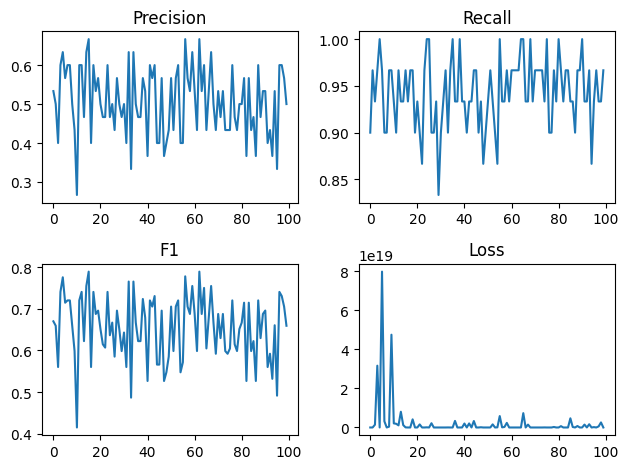


Precision: 0.533
Recall: 0.967
F1 Score: 0.687


In [10]:
%tb
main()